<a href="https://colab.research.google.com/github/tangshuting/daytoy/blob/master/EMW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pickle
import numpy as np
from scipy import integrate
import os,random
#os.environ["KERAS_BACKEND"] = "theano"
os.environ["KERAS_BACKEND"] = "tensorflow"
#os.environ["THEANO_FLAGS"]  = "device=cuda,floatX=float32"
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import pickle, random, sys, keras

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:

f = open(r'/content/drive/My Drive/EMW/2016.04C.multisnr.pkl','rb') #open的参数是pkl文件的路径
Xd = pickle.load(f,encoding='bytes')
print(type(Xd))   # dict
print(len(Xd))  #220=11（类别）×20（20个snr）
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])  # set()创建一个无序的不重复元素序列
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr)) # append末尾添加对象
X = np.vstack(X)

<class 'dict'>
220


In [0]:
np.random.seed(2016)
n_examples = X.shape[0]
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,n_examples), size= int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
# changed from x to combined data
# X_train = combined_Data[train_idx]
# X_test =  combined_Data[test_idx]
X_train = X[train_idx]
X_test =  X[test_idx]


In [6]:
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

in_shp = list(X_train.shape[1:])
print (X_train.shape, in_shp)
classes = mods

(81030, 2, 128) [2, 128]


In [0]:
# Set up some params
nb_epoch = 100    # number of epochs to train on
batch_size = 700  # training batch size


In [8]:
#fully connected neural network
dr = 0.1
model1 = keras.models.Sequential()
model1.add(Reshape(in_shp+[1], input_shape=in_shp))
model1.add(Dropout(dr))
model1.add(Flatten())
model1.add(Dense(128, activation='relu', kernel_initializer='he_normal', name="dense1"))
model1.add(Dropout(dr))
model1.add(Dense(128, activation='relu', kernel_initializer='he_normal', name="dense2"))
model1.add(Dropout(dr))
model1.add(Dense(64, activation='relu', kernel_initializer='he_normal', name="dense3"))
model1.add(Dropout(dr))
model1.add(Dense(64, activation='relu', kernel_initializer='he_normal', name="dense4"))
model1.add(Dropout(dr))
model1.add(Dense( len(classes), kernel_initializer='he_normal', name="dense5" ))
model1.add(Activation('softmax'))
model1.add(Reshape([len(classes)]))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 2, 128, 1)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 128, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense1 (Dense)               (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense2 (Dense)               (None, 128)               16512     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)              

In [9]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history=model1.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_split=0.05,
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
# we re-load the best weights once training is finished
model1.load_weights(filepath)

score = model1.evaluate(X_test, Y_test, batch_size=batch_size)
print(model1.metrics_names)
print (score)

Train on 76978 samples, validate on 4052 samples
Epoch 1/100
 - 2s - loss: 4.5418 - accuracy: 0.1575 - val_loss: 2.5925 - val_accuracy: 0.1972
Epoch 2/100
 - 2s - loss: 2.3677 - accuracy: 0.1928 - val_loss: 2.1268 - val_accuracy: 0.2058
Epoch 3/100
 - 2s - loss: 2.1391 - accuracy: 0.2023 - val_loss: 2.0980 - val_accuracy: 0.2105
Epoch 4/100
 - 2s - loss: 2.1141 - accuracy: 0.2088 - val_loss: 2.0813 - val_accuracy: 0.2266
Epoch 5/100
 - 2s - loss: 2.0838 - accuracy: 0.2384 - val_loss: 2.0394 - val_accuracy: 0.2520
Epoch 6/100
 - 2s - loss: 2.0358 - accuracy: 0.2485 - val_loss: 2.0057 - val_accuracy: 0.2596
Epoch 7/100
 - 2s - loss: 2.0119 - accuracy: 0.2554 - val_loss: 1.9952 - val_accuracy: 0.2633
Epoch 8/100
 - 2s - loss: 1.9974 - accuracy: 0.2629 - val_loss: 1.9808 - val_accuracy: 0.2700
Epoch 9/100
 - 2s - loss: 1.9866 - accuracy: 0.2706 - val_loss: 1.9678 - val_accuracy: 0.2796
Epoch 10/100
 - 2s - loss: 1.9702 - accuracy: 0.2755 - val_loss: 1.9521 - val_accuracy: 0.2850
Epoch 11/1

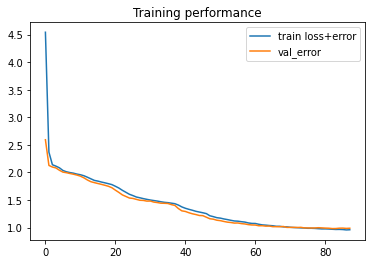

In [10]:
# Show loss curves
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [0]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

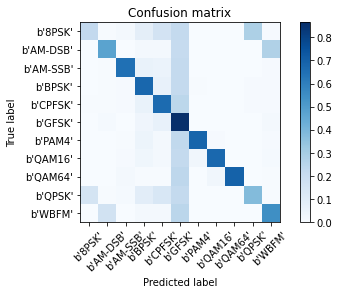

In [12]:
# Plot confusion matrix
test_Y_hat = model1.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes), len(classes)])
confnorm = np.zeros([len(classes), len(classes)])
for i in range(0, X_test.shape[0]):
    j = list(Y_test[i, :]).index(1)
    k = int(np.argmax(test_Y_hat[i, :]))
    conf[j, k] = conf[j, k] + 1
for i in range(0, len(classes)):
    confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
plot_confusion_matrix(confnorm, labels=classes)

Overall Accuracy:  0.15405606549243364
Overall Accuracy:  0.16097321209142296
Overall Accuracy:  0.15236686390532544
Overall Accuracy:  0.17167701863354037
Overall Accuracy:  0.18432510885341075
Overall Accuracy:  0.2736660929432014
Overall Accuracy:  0.4699975508204751
Overall Accuracy:  0.6241362290227048
Overall Accuracy:  0.7313997477931904
Overall Accuracy:  0.8488286066584464
Overall Accuracy:  0.855795482750062
Overall Accuracy:  0.8481856331769934
Overall Accuracy:  0.8815373388469958
Overall Accuracy:  0.9154339250493096
Overall Accuracy:  0.836033382425135
Overall Accuracy:  0.8906712734452122
Overall Accuracy:  0.9215880893300248
Overall Accuracy:  0.8453300124533001
Overall Accuracy:  0.882729736388273
Overall Accuracy:  0.9267928286852589


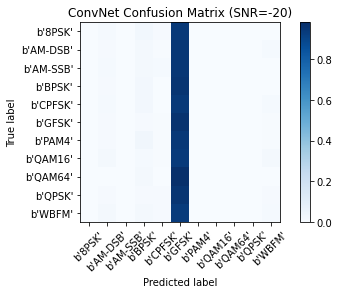

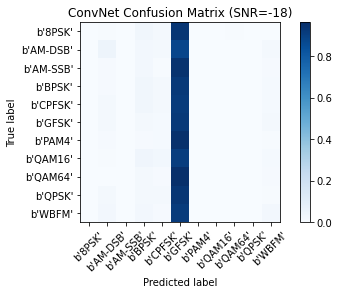

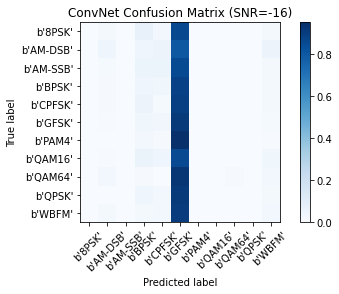

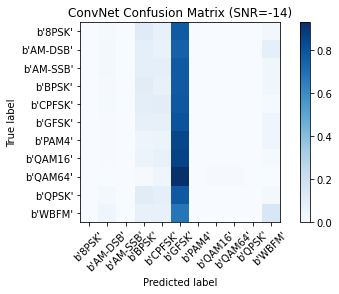

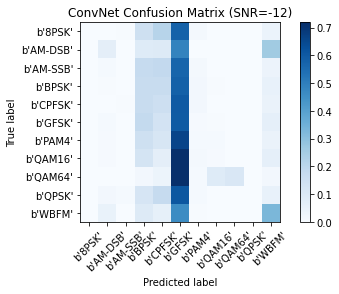

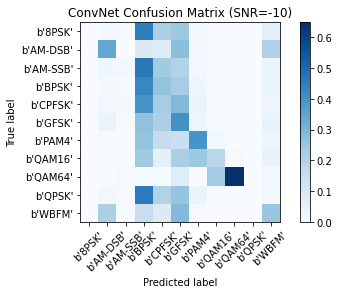

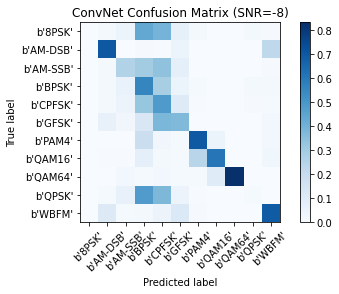

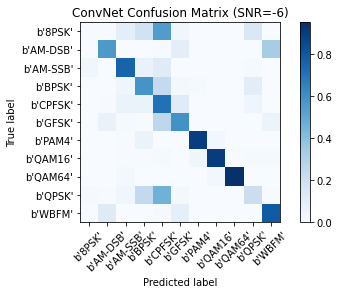

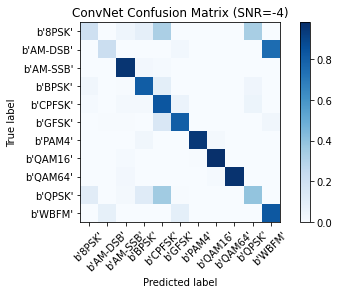

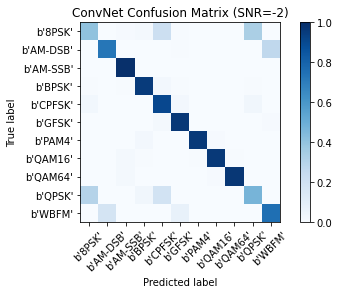

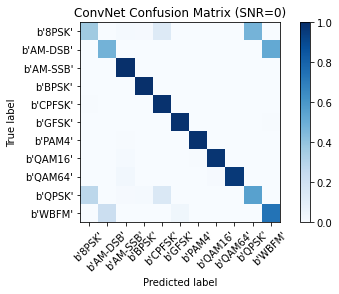

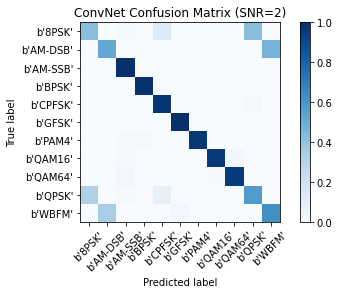

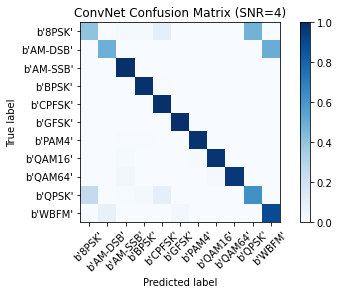

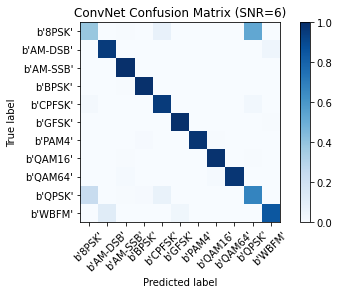

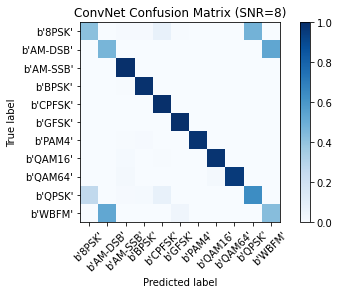

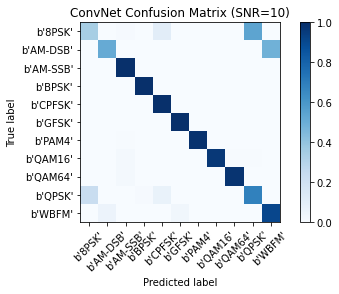

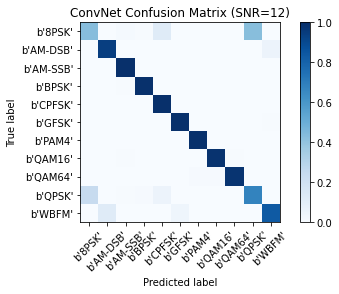

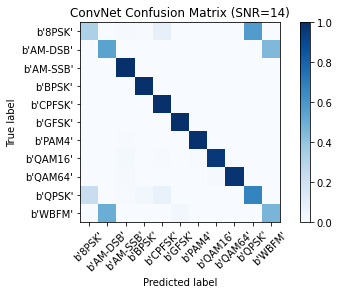

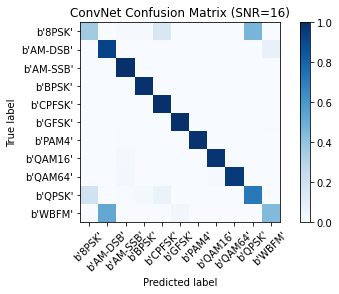

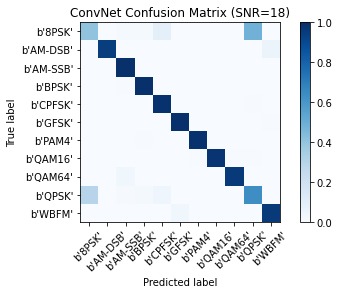

In [13]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = list(map(lambda x: lbl[x][1], test_idx))
    test_X_i = X_test[np.where(np.array(test_SNRs) == snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs) == snr)]

    # estimate classes
    test_Y_i_hat = model1.predict(test_X_i)
    conf = np.zeros([len(classes), len(classes)])
    confnorm = np.zeros([len(classes), len(classes)])
    for i in range(0, test_X_i.shape[0]):
        j = list(test_Y_i[i, :]).index(1)
        k = int(np.argmax(test_Y_i_hat[i, :]))
        conf[j, k] = conf[j, k] + 1
    for i in range(0, len(classes)):
        confnorm[i, :] = conf[i, :] / np.sum(conf[i, :])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)" % (snr))

    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor + ncor))
    acc[snr] = 1.0 * cor / (cor + ncor)

Text(0.5, 1.0, 'CNN2 Classification Accuracy on RadioML 2016.10 Alpha')

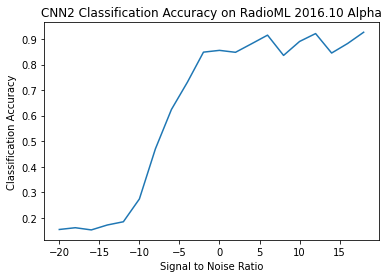

In [14]:
# Plot accuracy curve
plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")